<a href="https://colab.research.google.com/github/hvr2026/Exploring_Timegpt_Tabula_and_RDL/blob/main/TimeGPT/Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning


Fine-tuning is a powerful process for utilizing TimeGPT more effectively. Foundation models such as TimeGPT are pre-trained on vast amounts of data, capturing wide-ranging features and patterns. These models can then be specialized for specific contexts or domains. With fine-tuning, the model’s parameters are refined to forecast a new task, allowing it to tailor its vast pre-existing knowledge towards the requirements of the new data. Fine-tuning thus serves as a crucial bridge, linking TimeGPT’s broad capabilities to your tasks specificities.

In [51]:
!pip install nixtla

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate




In [5]:
# Initialize the Nixtla client with your API key
nixtla_client = NixtlaClient(
    api_key='your API key'
)

In [6]:

# Generate random time series data
np.random.seed(42)  # Set seed for reproducibility
n = 200  # Number of data points

# Create a DataFrame with timestamps and random values
df = pd.DataFrame({
    'timestamp': pd.date_range(start='2023-01-01', periods=n, freq='D'),  # Daily frequency
    'value': np.random.rand(n) * 100  # Random values between 0 and 100
})

# Display the first few rows of the dataset
print(df.head())


   timestamp      value
0 2023-01-01  37.454012
1 2023-01-02  95.071431
2 2023-01-03  73.199394
3 2023-01-04  59.865848
4 2023-01-05  15.601864


In [11]:

# Perform forecasting with a horizon of 7 days and fine-tuning
timegpt_fcst_finetune_df = nixtla_client.forecast(
    df=df, h=7, finetune_steps=10,
    time_col='timestamp', target_col='value',
)


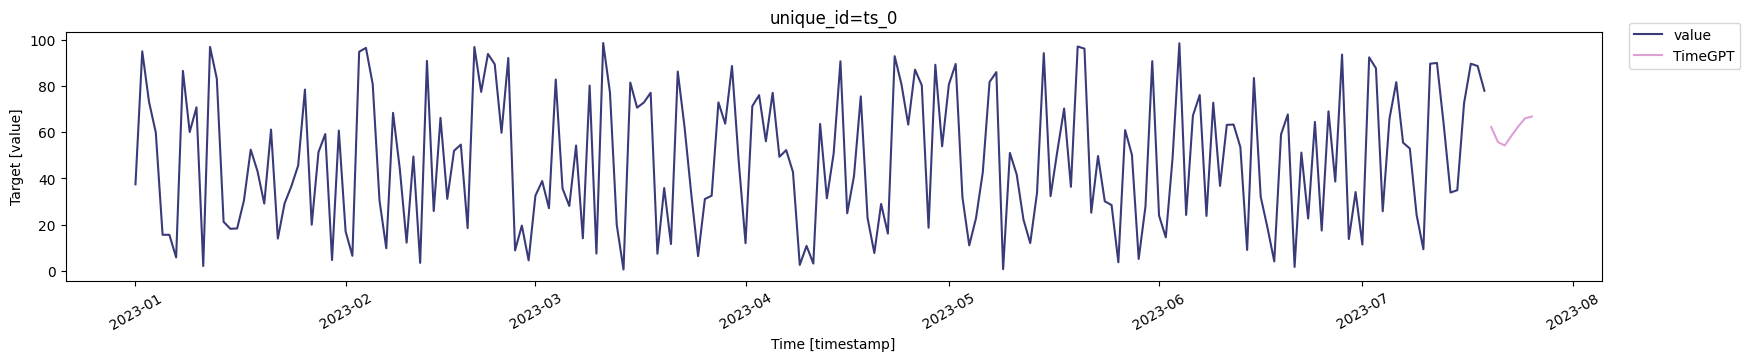

In [12]:

# Plot the original data and the forecast results
nixtla_client.plot(
    df, timegpt_fcst_finetune_df,
    time_col='timestamp', target_col='value',
)


In [13]:

# Split the data into training and testing sets
train = df[:-20]  # Use all but the last 20 points for training
test = df[-20:]   # Use the last 20 points for testing


In [15]:

# Define a range of fine-tune depths
depths = [1, 2, 3]

# Copy the test dataset for modification
test = test.copy()



In [44]:

# Split the data into training and testing sets
train = df[:-20]  # Use all but the last 20 points for training
test = df[-20:]   # Use the last 20 points for testing

# Define fine-tune depths
depths = [1, 2, 3, 4, 5]

# Set the forecast horizon to match the test set length
horizon = len(test)



In [46]:
# Perform forecasting for each depth and add predictions to the test set
test = test.copy()  # Ensure test is a modifiable copy
for depth in depths:
    preds_df = nixtla_client.forecast(
        df=train,
        h=horizon,  # Set horizon to match test set length
        finetune_steps=5,
        finetune_depth=depth,
        time_col='timestamp',
        target_col='value'
    )


In [47]:
# Extract predictions and ensure lengths match
preds = preds_df['TimeGPT'].values
assert len(preds) == len(test), "Prediction and test set lengths do not match!"

# Add predictions to the test set
test[f'TimeGPT_depth{depth}'] = preds


In [48]:

# Add a unique_id column to the test set for evaluation
test['unique_id'] = 0

# Evaluate predictions using MAE and MSE
evaluation = evaluate(
    test,
    metrics=[mae, mse],
    id_col="unique_id",
    time_col="timestamp",
    target_col="value",
    models=[f'TimeGPT_depth{depth}' for depth in depths]
)



In [49]:
# Print evaluation results
print("\nEvaluation Results:")
print(evaluation)


Evaluation Results:
   unique_id metric  TimeGPT_depth1  TimeGPT_depth2  TimeGPT_depth3  \
0          0    mae       27.068358       27.050972       26.962692   
1          0    mse      897.117957      894.099333      884.594327   

   TimeGPT_depth4  TimeGPT_depth5  
0       26.731891       26.655010  
1      864.688719      855.271667  
